# Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Pip Installs

In [2]:
!pip install torchsummary
!pip install albumentations

     |████████████████████████████████| 634kB 2.8MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=fb42ca8dbc351260231b5f4192f745e8b0ae184882af54c0d6ca2ac262964eca
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


# Imports



In [3]:
import time
from torchsummary import summary
from torch.utils.data import DataLoader
import time
import sys
sys.path.append('/content/gdrive/My Drive/EVA/EndGame/Utils/')
from models import *
from utils import *
from loss import *
from dataloader.serialize_filepaths import *
from dataloader.data_loader import *
from train import *
from config import *
import validation as test
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip, Resize

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Move dataset to colab
This significantly increases execution time, since reading from drive is huge time consuming




In [4]:
start_time = time.time()
!mkdir dataset_zip
!mkdir dataset
!cp -r "/content/gdrive/My Drive/EVA/15A/dataset/fg_bg.zip" "/content/dataset_zip/"
!cp -r "/content/gdrive/My Drive/EVA/15A/dataset/dense_depth.zip" "/content/dataset_zip/"
!cp -r "/content/gdrive/My Drive/EVA/15A/dataset/fg_bg_mask.zip" "/content/dataset_zip/"
!cp -r "/content/gdrive/My Drive/EVA/15A/dataset/bg" "/content/dataset/"
!unzip -q "/content/dataset_zip/fg_bg.zip" -d "/content/dataset/fg_bg"
!unzip -q "/content/dataset_zip/fg_bg_mask.zip" -d "/content/dataset/fg_bg_mask"
!unzip -q "/content/dataset_zip/dense_depth.zip" -d "/content/dataset/dense_depth"
end_time = time.time()
print("Time to move data to colab is ", (end_time-start_time)/60)

Time to move data to colab is  4.1004737655321755


# Serialize Dataset paths

* Serialize Datapaths and Store it on initial read
* Once pickling is done, this can be commented for further runs
* This to reduce the time in framing the dataset paths


In [5]:
# datasetPaths = {"bg":"/content/dataset/bg",
#                 "fg_bg":"/content/dataset/fg_bg",
#                 "fg_bg_mask":"/content/dataset/fg_bg_mask",
#                 "dense_depth":"/content/dataset/dense_depth"}

# serialize_filepaths_data(datasetPaths, "/content/gdrive/My Drive/EVA/15A/")

# Model
U2Net
* Total params: 1,769,306




In [6]:
device = getDevice()
print(device)
model = U2NETP().to(device)
model.aux_logits=False
summary(model, input_size=(6, 96, 96))

cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           3,520
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
          REBNCONV-4           [-1, 64, 96, 96]               0
            Conv2d-5           [-1, 16, 96, 96]           9,232
       BatchNorm2d-6           [-1, 16, 96, 96]              32
              ReLU-7           [-1, 16, 96, 96]               0
          REBNCONV-8           [-1, 16, 96, 96]               0
         MaxPool2d-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 16, 48, 48]           2,320
      BatchNorm2d-11           [-1, 16, 48, 48]              32
             ReLU-12           [-1, 16, 48, 48]               0
         REBNCONV-13           [-1, 16, 48, 48]               0
        MaxPool2d-14           [-1, 16,

# Data Loader


*   Batch Size - 128
*   Initial Image size - 112*112



In [7]:
bg_transforms_list = [Resize(112,112)]
fg_bg_transforms_list = [Resize(112,112)]
fg_bg_mask_transforms_list = [Resize(112,112)]
dense_depth_transforms_list = [Resize(112,112)]


train_transforms = {"bg":getAlbumTransformation(bg_transforms_list), "fg_bg":getAlbumTransformation(fg_bg_transforms_list)}
train_target_transforms = {"fg_bg_mask":getAlbumTransformation(fg_bg_mask_transforms_list), "dense_depth":getAlbumTransformation(dense_depth_transforms_list)}

train_dataset, test_dataset = EndGameTrainTestDataSet("/content/gdrive/My Drive/EVA/15A/c_dataset_filepaths.pickle", "/content/dataset/", train_split=70, 
                                             train_transforms=train_transforms, train_target_transforms=train_target_transforms, 
                                             test_transforms=train_transforms, test_target_transforms=train_target_transforms)
print("Train dataset length ",len(train_dataset))
print("Test dataset lenght ", len(test_dataset))
BATCH_SIZE = 128
trainloader = DataLoader(train_dataset, num_workers=8, batch_size=BATCH_SIZE)
testloader = DataLoader(test_dataset, num_workers=8, batch_size=BATCH_SIZE)



Train dataset length  280000
Test dataset lenght  120000


# Dataset Samples


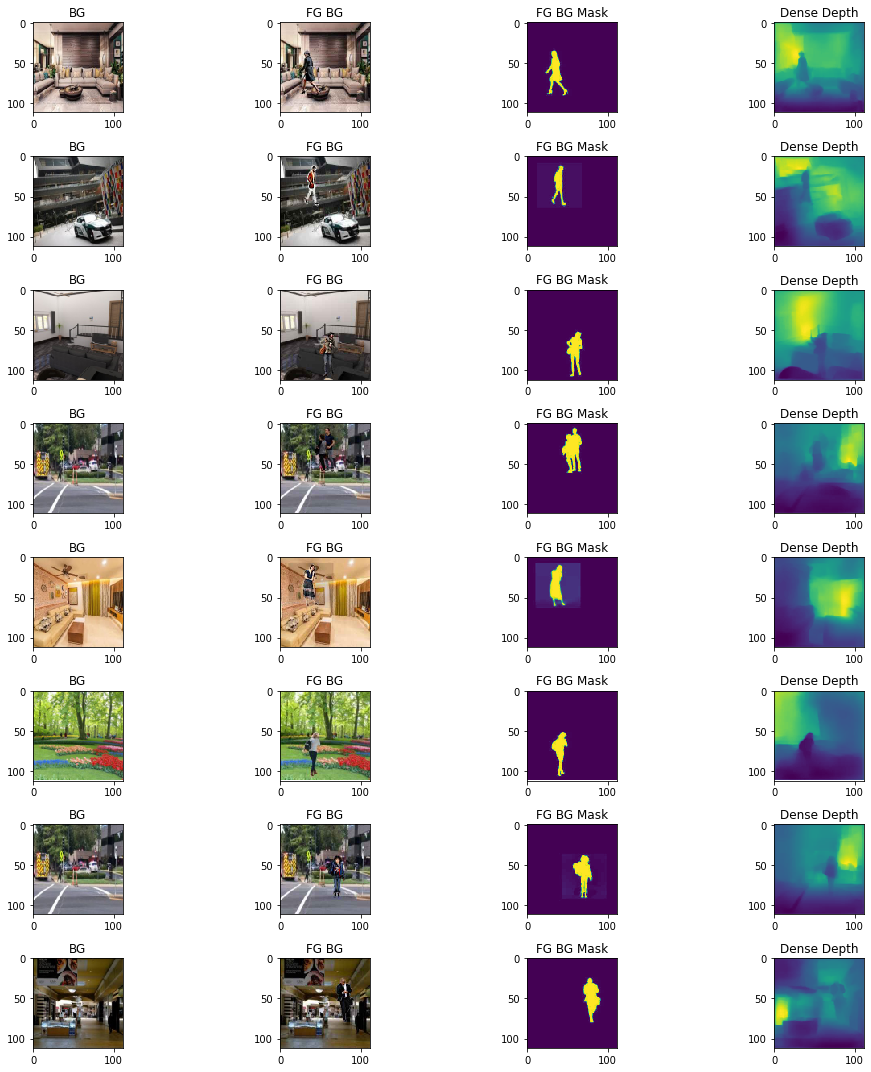

In [8]:
plot_endgame_images(next(iter(trainloader)), 8)

# Set loss, epochs and other hyper parameters

In [9]:
EPOCHS = 2
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.01
div_factor = 10
min_lr = max_lr/div_factor
depth_criterion = muti_bce_loss_fusion
seg_criterion = muti_bce_loss_fusion
optimizer = optim.Adam(model.parameters(), lr=min_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=EPOCHS, pct_start=0.5, div_factor=div_factor, final_div_factor=1, anneal_strategy='linear',
                       cycle_momentum=False)
modelName = "segment_depth"
modelDir = "/content/gdrive/My Drive/EVA/EndGame/saved_models/"
model.load_state_dict(torch.load(modelDir+modelName+"_96.pt"))
model.cuda()

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

# Train and Test

In [10]:
for epoch in range(EPOCHS):
  start_time = time.time()
  print('EPOCH : ', epoch, ' LR : ', scheduler.get_lr())
  train(model, device, trainloader, optimizer, depth_criterion, seg_criterion, scheduler=scheduler)
  test.__test(model, device, testloader, depth_criterion, seg_criterion)
  torch.save(model.state_dict(), modelDir+modelName+"__112.pt")
  end_time = time.time()
  print("--- %s Mins ---" % int((end_time - start_time)/60))

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/2188 [00:00<?, ?it/s]

EPOCH :  0  LR :  [0.001]


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Batch_id=2187 Train set: Loss=4.0504715184407  Accuracy IOU(Segmentation)=0.9627762747514995 RMSE(Dense depth)=0.06933846324682236  Avg Batch Time=0.6947219371795654 Secs: 100%|██████████| 2188/2188 [43:45<00:00,  1.20s/it]
Batch_id=937 Test set: Average loss: 4.042815237919659 Accuracy IOU(Segmentation)=0.963462509180091 RMSE(Dense depth)=0.06773336976766586  Avg Batch Time=0.2548727

--- 51 Mins ---
EPOCH :  1  LR :  [0.009995886654478977]


Batch_id=2187 Train set: Loss=4.02396703823393  Accuracy IOU(Segmentation)=0.9652902764846469 RMSE(Dense depth)=0.0624389611184597  Avg Batch Time=0.6957135200500488 Secs: 100%|██████████| 2188/2188 [43:48<00:00,  1.20s/it]
Batch_id=937 Test set: Average loss: 4.016250446152839 Accuracy IOU(Segmentation)=0.9668832675562538 RMSE(Dense depth)=0.059237413108348846  Avg Batch Time=0.2569742202758789 Secs): 100%|██████████| 938/938 [07:33<00:00,  2.07it/s]


--- 51 Mins ---


# Results

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


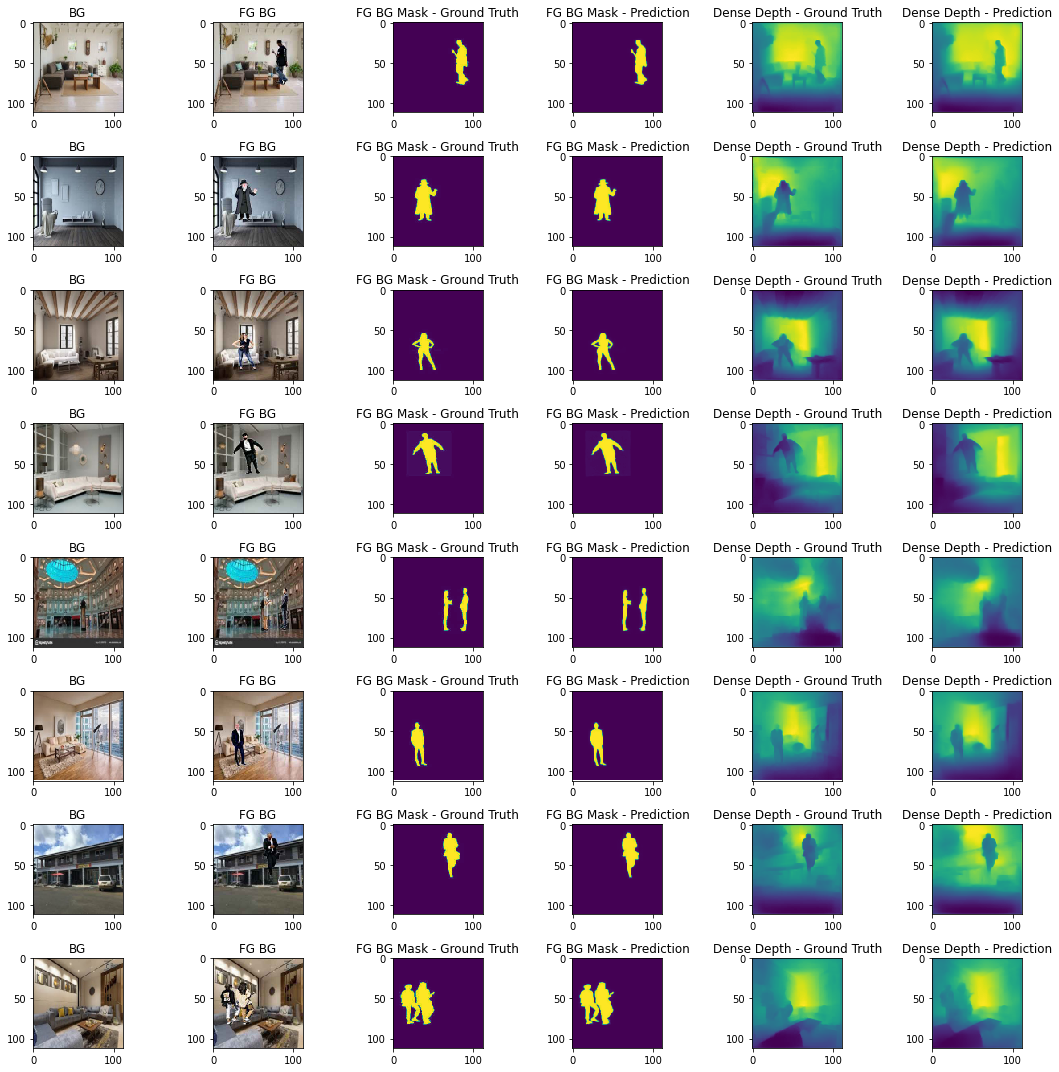

In [11]:
show_predictions(model, testloader, device, noOfImages=8)